### Obtain spectra for the sources and add additional spec-zs from SIMBAD

In [1]:
%matplotlib inline
import sys, os, glob

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table

In [2]:
import scienceplots

plt.style.use(['bright', 'science', 'no-latex', 'notebook'])

### Read the DES AGN table:

https://ui.adsabs.harvard.edu/abs/2022MNRAS.516.2736B/abstract

In [3]:
data_agn = ascii.read('des_agn.txt')
cat_agn = SkyCoord(data_agn['RA'], data_agn['dec'], unit='deg')
data_agn

Name,RA,dec,$g$,SNR,$\sigma_{\rm{LB}}$,$\log\ \frac{M_{\ast}}{M_{\odot}}$,$\Delta\chi_\nu^2$,"$\log\ \frac{\tau_{\rm{\textsc{DRW},rest}}}{\rm{days}}$",$z_{\rm{ph}}$,$z_{\rm{sp}}$,$z_{\rm{sp}}$ source,$W1{-}W2$,$\log \frac{F_{2-7 {\rm{\ keV}}}}{{\rm{erg\ s}}^{-1} {\rm{\ cm}}^{-2}}$,Field
str20,float64,float64,float64,float64,float64,str14,float64,str16,str22,float64,str4,float64,float64,str5
J032833.79-271056.42,52.1408,-27.1823,23.7,14.2,13.3,$10.1 \pm 0.4$,0.1,$3.2 \pm 0.6$,$1.02^{+0.03}_{-0.04}$,nan,None,0.4,nan,SN-C3
J032951.20-271057.43,52.4633,-27.1826,23.4,15.3,12.7,$7.8 \pm 0.7$,0.1,$1.9 \pm 0.3$,$0.24^{+0.04}_{-0.02}$,nan,None,18.6,nan,SN-C3
J032944.64-271107.53,52.436,-27.1854,23.4,20.1,16.3,$9.4 \pm 0.5$,0.0,$2.4 \pm 0.8$,$1.09^{+0.02}_{-0.02}$,nan,None,0.9,nan,SN-C3
J032845.45-271117.18,52.1894,-27.1881,21.5,22.8,18.3,$9.7 \pm 0.0$,5.0,$1.7 \pm 0.2$,$1.30^{+0.10}_{-0.15}$,nan,None,1.1,nan,SN-C3
J032843.19-271117.75,52.1799,-27.1883,23.8,13.4,12.4,$8.8 \pm 0.5$,0.0,$2.7 \pm 0.8$,$0.60^{+0.25}_{-0.05}$,nan,None,nan,nan,SN-C3
J032850.22-271208.00,52.2093,-27.2022,19.2,26.1,20.3,$10.2 \pm 0.6$,0.0,$2.7 \pm 0.6$,$0.90^{+0.40}_{-0.30}$,nan,None,1.1,nan,SN-C3
J032913.11-271213.79,52.3046,-27.2038,22.9,21.6,17.2,$10.4 \pm 0.5$,0.3,$2.2 \pm 0.7$,$1.25^{+0.15}_{-0.10}$,nan,None,1.0,nan,SN-C3
J032847.11-271553.99,52.1963,-27.265,21.1,23.6,19.0,$7.3 \pm 0.1$,3.2,$3.6 \pm 0.4$,$0.08^{+0.03}_{-0.04}$,2.9784,2dF,18.1,nan,SN-C3
J033039.78-271740.97,52.6658,-27.2947,24.1,10.0,11.7,$9.6 \pm 0.5$,0.4,$1.9 \pm 0.4$,$1.45^{+0.02}_{-0.02}$,nan,None,nan,nan,SN-C3


In [4]:
print(data_agn.columns)

<TableColumns names=('Name','RA','dec','$g$','SNR','$\sigma_{\rm{LB}}$','$\log\ \frac{M_{\ast}}{M_{\odot}}$','$\Delta\chi_\nu^2$','$\log\ \frac{\tau_{\rm{\textsc{DRW},rest}}}{\rm{days}}$','$z_{\rm{ph}}$','$z_{\rm{sp}}$','$z_{\rm{sp}}$ source','$W1{-}W2$','$\log \frac{F_{2-7 {\rm{\ keV}}}}{{\rm{erg\  s}}^{-1} {\rm{\ cm}}^{-2}}$','Field')>


### Match to SIMBAD

In [5]:
M_star = data_agn[r'$\log\ \frac{M_{\ast}}{M_{\odot}}$']
M_star = np.array([d.split(' ')[0][1:] for d in M_star.data], dtype=float)

dChi2 = data_agn[r'$\Delta\chi_\nu^2$']
dChi2 = np.array(dChi2, dtype=float)
mask_dwarf_agn = (M_star < 10) & (dChi2 > 2)

In [6]:
from astroquery.simbad import Simbad

# Add the redshift information
customSimbad = Simbad()
customSimbad.add_votable_fields('rvz_qual','rvz_wavelength','z_value', 'rvz_bibcode', 'flux(i)')

result_table = customSimbad.query_region(cat_agn, radius=0.5*u.arcsec)

# Sources with RVZ_WAVELENGTH == 'O' and rvz_qual!='E' should have an optical spectrum
print(len(result_table[result_table['RVZ_WAVELENGTH']=='O'])) 
#TODO: Possibly add N (near-ir)

mask_spec_simbad = ((result_table['RVZ_WAVELENGTH']=='O') | (result_table['RVZ_WAVELENGTH']=='N'))  & (result_table['RVZ_QUAL']!='E') 

result_table.write('result_table.txt', format='csv', overwrite=True)

168


/Users/colinburke/miniconda3/lib/python3.11/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '3:28:33.792 -27:10:56.28': No astronomical object found :  
  warnings.warn("Warning: The script line number %i raised "
/Users/colinburke/miniconda3/lib/python3.11/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 5 raised an error (recorded in the `errors` attribute of the result table): '3:29:44.64 -27:11:07.44': No astronomical object found :  
  warnings.warn("Warning: The script line number %i raised "
/Users/colinburke/miniconda3/lib/python3.11/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 7 raised an error (recorded in the `errors` attribute of the result table): '3:28:43.176 -27:11:17.88': No astronomical object found :  
  warnings.warn("Warning: The script line number %i raised "
/User

In [8]:
result_table

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,RVZ_QUAL,RVZ_WAVELENGTH,Z_VALUE,RVZ_BIBCODE,FLUX_i,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,,,,mag,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,str1,str1,float64,object,float32,int32
DES J032850.22-271207.8,03 28 50.201,-27 12 07.81,7,7,--,--,0,C,O,2017AJ....153..107T,D,O,0.8030000,2017AJ....153..107T,19.181,6
[CBP2015] cdfs2 r 20120118 196A,03 28 47.1168,-27 15 53.960,14,14,0.703,1.244,90,A,O,2020yCat.1350....0G,E,O,0.2300000,2015A&A...584A..62C,--,8
Gaia DR3 5060529754629842816,03 30 25.4703,-27 28 21.939,14,14,0.274,0.460,90,A,O,2020yCat.1350....0G,,,--,,--,14
2XMM J033204.0-273726,03 32 04.06,-27 37 25.8,6,6,100.000,100.000,0,C,X,2016ApJS..224...15X,C,O,0.9660000,2015ApJ...815..129S,--,42
[VV2006] J033226.5-274036,03 32 26.4998,-27 40 35.910,14,14,0.135,0.251,90,A,O,2020yCat.1350....0G,C,O,1.0310000,2010ApJS..191..124S,19.762,43
[VV2006] J033227.0-274105,03 32 27.0132,-27 41 05.357,14,14,0.127,0.230,90,A,O,2020yCat.1350....0G,C,,0.7423000,2010A&A...512A..12B,19.11,44
[GYO2019] GS-44b,03 32 27.011,-27 41 05.44,7,7,13.000,0.000,90,C,R,2019ApJ...875...80G,,,--,,--,44
ACS-GC 90042521,03 32 30.2159,-27 45 04.590,8,8,--,--,0,C,O,2012MNRAS.426..360V,C,O,0.7368000,2011AJ....141...64X,21.623,45


### Add new spec-z into the table

In [9]:
idx = result_table['SCRIPT_NUMBER_ID'].data.data - 1
idx_simbad_specz = idx[(result_table['RVZ_WAVELENGTH']=='O')]

data_agn_updated = data_agn.copy()

for j,i in enumerate(idx_simbad_specz):
    # Update if no existing spec-z
    if ~np.isfinite(data_agn_updated[r'$z_{\rm{sp}}$'][i]):
        data_agn_updated[r'$z_{\rm{sp}}$ source'][i] = 'SIMB'
        data_agn_updated[r'$z_{\rm{sp}}$'][i] = result_table['Z_VALUE'][j]
    # Check for inconsistent spec-z's...

mask_specz_updated = np.isfinite(data_agn_updated[r'$z_{\rm{sp}}$'].data)
print(len(data_agn_updated[mask_specz_updated]))
mask_specz = np.isfinite(data_agn[r'$z_{\rm{sp}}$'].data)
print(len(data_agn[mask_specz]))

data_agn_updated.write('des_agn_updated.txt', format='ascii', overwrite=True)

202
146


/Users/colinburke/miniconda3/lib/python3.11/site-packages/astropy/table/column.py:1362: UserWarning: Warning: converting a masked element to nan.
  self.data[index] = value


In [10]:
data_agn_updated

Name,RA,dec,$g$,SNR,$\sigma_{\rm{LB}}$,$\log\ \frac{M_{\ast}}{M_{\odot}}$,$\Delta\chi_\nu^2$,"$\log\ \frac{\tau_{\rm{\textsc{DRW},rest}}}{\rm{days}}$",$z_{\rm{ph}}$,$z_{\rm{sp}}$,$z_{\rm{sp}}$ source,$W1{-}W2$,$\log \frac{F_{2-7 {\rm{\ keV}}}}{{\rm{erg\ s}}^{-1} {\rm{\ cm}}^{-2}}$,Field
str20,float64,float64,float64,float64,float64,str14,float64,str16,str22,float64,str4,float64,float64,str5
J032833.79-271056.42,52.1408,-27.1823,23.7,14.2,13.3,$10.1 \pm 0.4$,0.1,$3.2 \pm 0.6$,$1.02^{+0.03}_{-0.04}$,nan,None,0.4,nan,SN-C3
J032951.20-271057.43,52.4633,-27.1826,23.4,15.3,12.7,$7.8 \pm 0.7$,0.1,$1.9 \pm 0.3$,$0.24^{+0.04}_{-0.02}$,nan,None,18.6,nan,SN-C3
J032944.64-271107.53,52.436,-27.1854,23.4,20.1,16.3,$9.4 \pm 0.5$,0.0,$2.4 \pm 0.8$,$1.09^{+0.02}_{-0.02}$,nan,None,0.9,nan,SN-C3
J032845.45-271117.18,52.1894,-27.1881,21.5,22.8,18.3,$9.7 \pm 0.0$,5.0,$1.7 \pm 0.2$,$1.30^{+0.10}_{-0.15}$,nan,None,1.1,nan,SN-C3
J032843.19-271117.75,52.1799,-27.1883,23.8,13.4,12.4,$8.8 \pm 0.5$,0.0,$2.7 \pm 0.8$,$0.60^{+0.25}_{-0.05}$,nan,None,nan,nan,SN-C3
J032850.22-271208.00,52.2093,-27.2022,19.2,26.1,20.3,$10.2 \pm 0.6$,0.0,$2.7 \pm 0.6$,$0.90^{+0.40}_{-0.30}$,0.803,SIMB,1.1,nan,SN-C3
J032913.11-271213.79,52.3046,-27.2038,22.9,21.6,17.2,$10.4 \pm 0.5$,0.3,$2.2 \pm 0.7$,$1.25^{+0.15}_{-0.10}$,nan,None,1.0,nan,SN-C3
J032847.11-271553.99,52.1963,-27.265,21.1,23.6,19.0,$7.3 \pm 0.1$,3.2,$3.6 \pm 0.4$,$0.08^{+0.03}_{-0.04}$,2.9784,2dF,18.1,nan,SN-C3
J033039.78-271740.97,52.6658,-27.2947,24.1,10.0,11.7,$9.6 \pm 0.5$,0.4,$1.9 \pm 0.4$,$1.45^{+0.02}_{-0.02}$,nan,None,nan,nan,SN-C3


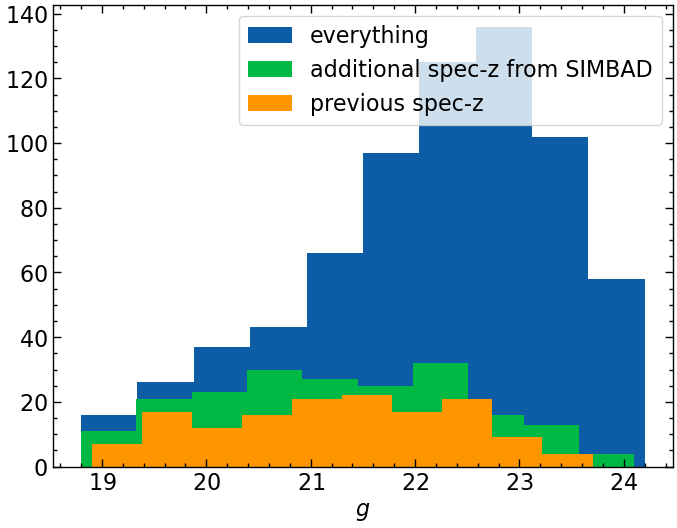

In [12]:
mask_specz_updated = np.isfinite(data_agn_updated[r'$z_{\rm{sp}}$'].data)
plt.hist(data_agn_updated['$g$'], label='everything')
plt.hist(data_agn_updated['$g$'][mask_specz_updated], label='additional spec-z from SIMBAD')
mask_specz = np.isfinite(data_agn[r'$z_{\rm{sp}}$'].data)
plt.hist(data_agn['$g$'][mask_specz], label='previous spec-z')
plt.xlabel('$g$')
plt.legend(frameon=True, loc=1)

In [13]:
z_ph = data_agn[r'$z_{\rm{ph}}$'].data
z_ph = np.array([d[1:4] for d in z_ph], dtype=float)

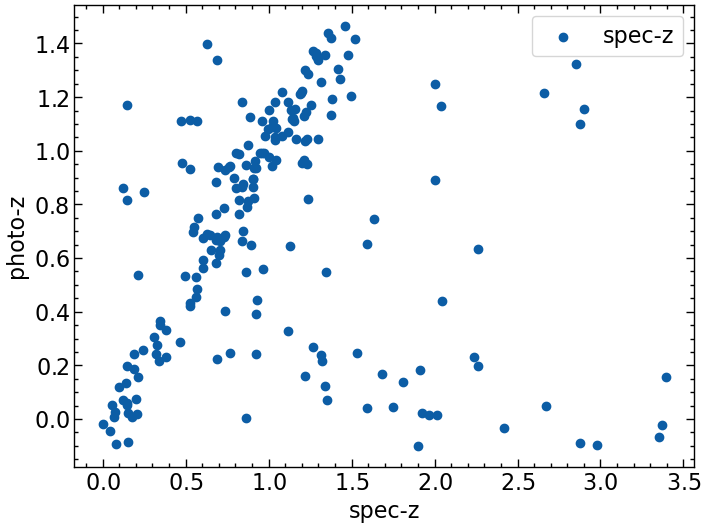

In [15]:
plt.scatter(data_agn_updated[r'$z_{\rm{sp}}$'], z_ph+np.random.uniform(-0.1, 0.1, len(z_ph)), label='spec-z')
#plt.scatter(z_ph[mask_specz_updated], data_agn_updated[r'$z_{\rm{sp}}$'][mask_specz_updated])
#plt.scatter(z_ph[mask_specz & mask_specz_updated], data_agn_updated[r'$z_{\rm{sp}}$'][mask_specz & mask_specz_updated], label='updated spec-z')
plt.xlabel('spec-z')
plt.ylabel('photo-z')
plt.legend(frameon=True)